# GPT Triples 数据集分析

本 notebook 用于分析 `/mnt/data/retrieve` 下 `webqsp` 和 `cwq` 的 `gpt_triples.pth` 数据集，主要关注：

- 每个问题 GPT 选择的三元组数量分布（规模）
- 涉及实体数、关系数等简单复杂度指标
- WebQSP 与 CWQ 之间的差异

后续可以在此基础上，将这些复杂度特征与检索/AnswerRecall 曲线、动态 K 策略关联起来。

In [26]:
import torch
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
sns.set_context("talk")

base_dir = Path("/mnt/data/retrieve")
datasets = ["webqsp", "cwq"]

print("Base dir:", base_dir)
for name in datasets:
    path = base_dir / name / "gpt_triples.pth"
    print(f"{name}: exists={path.exists()} -> {path}")

Base dir: /mnt/data/retrieve
webqsp: exists=True -> /mnt/data/retrieve/webqsp/gpt_triples.pth
cwq: exists=True -> /mnt/data/retrieve/cwq/gpt_triples.pth


In [27]:
def load_gpt_triples(dataset_name: str):
    path = base_dir / dataset_name / "gpt_triples.pth"
    data = torch.load(path, map_location="cpu")
    if not isinstance(data, dict):
        raise TypeError(f"Expected dict from {path}, got {type(data)}")
    print(f"Loaded {dataset_name}: {len(data)} samples")
    return data


gpt_data = {name: load_gpt_triples(name) for name in datasets}

Loaded webqsp: 1628 samples
Loaded cwq: 3531 samples


In [28]:
def triples_to_stats(sample_id: str, triples):
    # Convert a single sample's (h, r, t) list into basic stats
    n_triples = len(triples)
    entities = set()
    relations = set()
    for t in triples:
        if not isinstance(t, (list, tuple)) or len(t) != 3:
            continue
        h, r, v = t
        entities.add(str(h))
        entities.add(str(v))
        relations.add(str(r))
    n_entities = len(entities)
    n_relations = len(relations)
    branching = n_triples / (n_entities + 1e-6) if n_entities > 0 else 0.0
    return {
        "sample_id": sample_id,
        "num_triples": n_triples,
        "num_entities": n_entities,
        "num_relations": n_relations,
        "branching": branching,
    }


rows = []
for name, data in gpt_data.items():
    for sid, triples in data.items():
        stats = triples_to_stats(sid, triples)
        stats["dataset"] = name
        rows.append(stats)


df = pd.DataFrame(rows)
print("DataFrame shape:", df.shape)
df.head()

DataFrame shape: (5159, 6)


,sample_id,num_triples,num_entities,num_relations,branching,dataset
0,WebQTest-0,6,3,4,1.999999,webqsp
1,WebQTest-1,20,16,6,1.250000,webqsp
2,WebQTest-3,2,2,2,1.000000,webqsp
3,WebQTest-6,4,5,3,0.800000,webqsp
4,WebQTest-7,3,4,3,0.750000,webqsp


In [29]:
df.describe(include="all")

,sample_id,num_triples,num_entities,num_relations,branching,dataset
count,5159,5159.000000,5159.000000,5159.000000,5159.000000,5159
unique,5159,NaN,NaN,NaN,NaN,2
top,WebQTest-213_71621b15ae9777fca8c1becaa188a3bb,NaN,NaN,NaN,NaN,cwq
freq,1,NaN,NaN,NaN,NaN,3531
mean,NaN,4.183175,4.252568,2.532855,0.863821,NaN
std,NaN,3.637295,3.397474,1.697350,0.426241,NaN
min,NaN,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,2.000000,3.000000,2.000000,0.666666,NaN
50%,NaN,3.000000,3.000000,2.000000,0.888889,NaN
75%,NaN,5.000000,5.000000,3.000000,1.000000,NaN


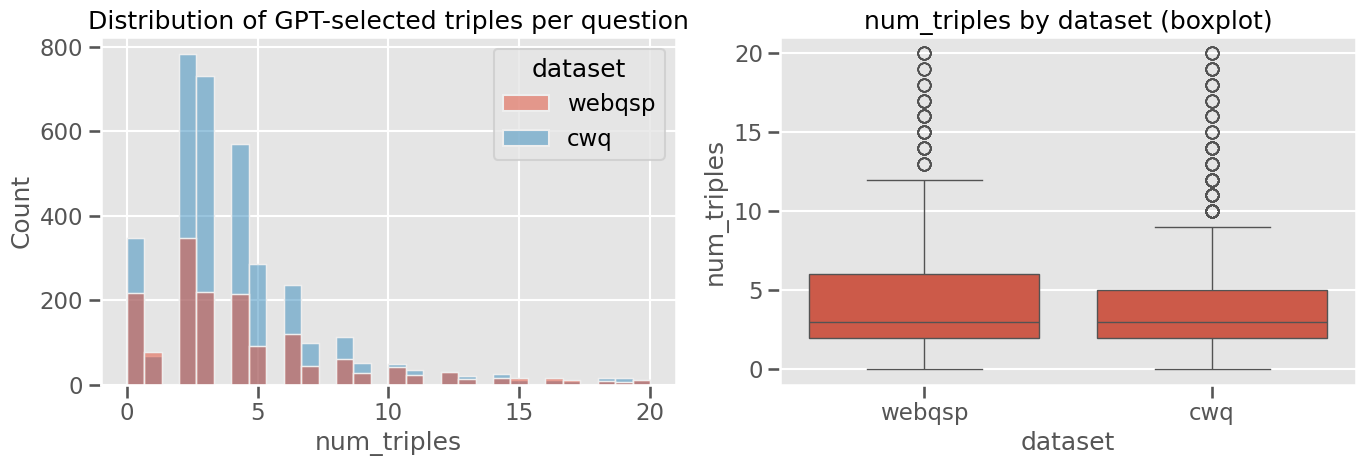

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(data=df, x="num_triples", hue="dataset", bins=30, kde=False, ax=axes[0])
axes[0].set_title("Distribution of GPT-selected triples per question")
axes[0].set_xlabel("num_triples")

sns.boxplot(data=df, x="dataset", y="num_triples", ax=axes[1])
axes[1].set_title("num_triples by dataset (boxplot)")

plt.tight_layout()
plt.show()

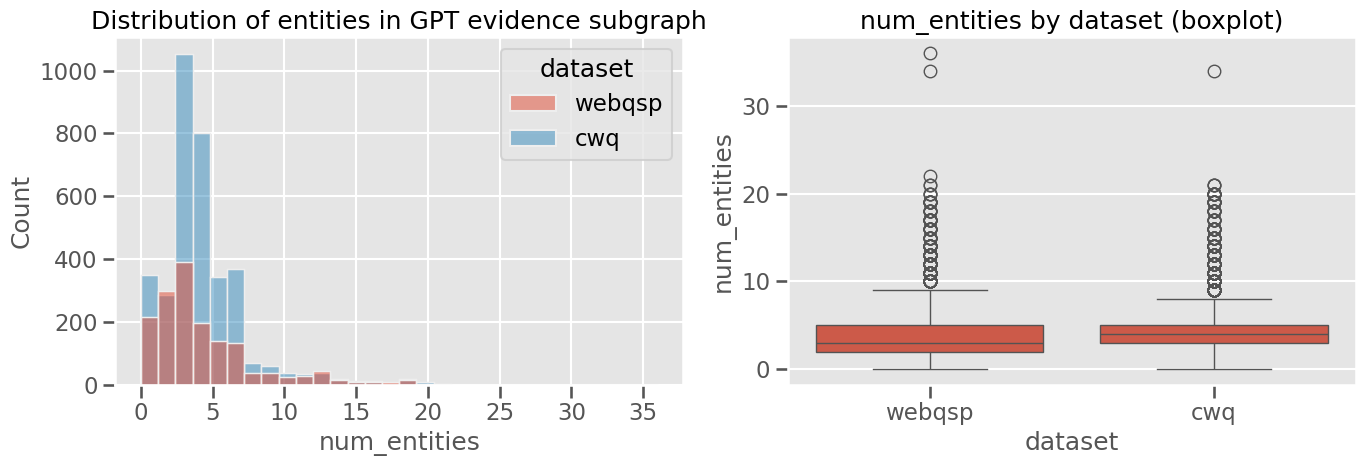

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(data=df, x="num_entities", hue="dataset", bins=30, kde=False, ax=axes[0])
axes[0].set_title("Distribution of entities in GPT evidence subgraph")
axes[0].set_xlabel("num_entities")

sns.boxplot(data=df, x="dataset", y="num_entities", ax=axes[1])
axes[1].set_title("num_entities by dataset (boxplot)")

plt.tight_layout()
plt.show()

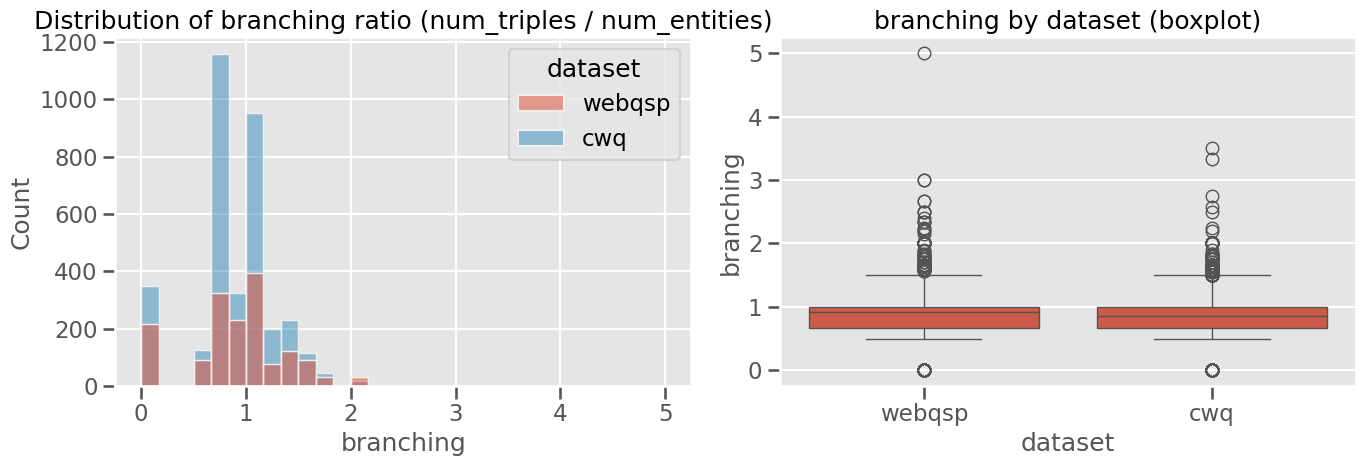

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(data=df, x="branching", hue="dataset", bins=30, kde=False, ax=axes[0])
axes[0].set_title("Distribution of branching ratio (num_triples / num_entities)")
axes[0].set_xlabel("branching")

sns.boxplot(data=df, x="dataset", y="branching", ax=axes[1])
axes[1].set_title("branching by dataset (boxplot)")

plt.tight_layout()
plt.show()

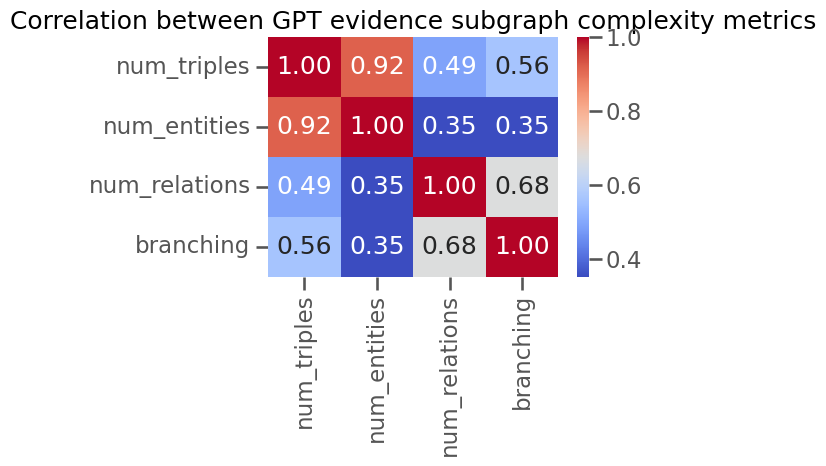

In [33]:
corr_cols = ["num_triples", "num_entities", "num_relations", "branching"]
corr = df[corr_cols].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation between GPT evidence subgraph complexity metrics")
plt.tight_layout()
plt.show()

## 下一步：与检索难度/最优 K 对齐

在本 notebook 的基础上，你可以进一步：

1. 载入检索器在同一 split 上的输出（scores、labels），计算 AnswerRecall@K 曲线；
2. 为每个问题计算：
   - `K*`: 覆盖全部 GPT 选择三元组所需的最小 K；
   - `ΔAnswerRecall = A(150) - A(50)` 等指标；
3. 分桶比较：按 `num_triples` 或 `branching` 分组，看 `K*` 与 `ΔAnswerRecall` 的变化趋势；
4. 在此基础上设计/评估动态 K 策略。


In [ ]:
import numpy as np

# Compute global quantiles for num_triples
t_all = df["num_triples"].values
q20, q40, q60, q80 = np.quantile(t_all, [0.2, 0.4, 0.6, 0.8])
print("Global num_triples quantiles (20/40/60/80%):", q20, q40, q60, q80)


def difficulty_from_triples(t: int) -> int:
    if t <= q20:
        return 1
    if t <= q40:
        return 2
    if t <= q60:
        return 3
    if t <= q80:
        return 4
    return 5


df["difficulty_level"] = df["num_triples"].apply(difficulty_from_triples)
print("Difficulty level value counts:", df["difficulty_level"].value_counts().sort_index())

Global num_triples quantiles (20/40/60/80%): 2.0 3.0 4.0 6.0
Difficulty level value counts: difficulty_level
1    1843
2     950
3     787
4     735
5     844
Name: count, dtype: int64


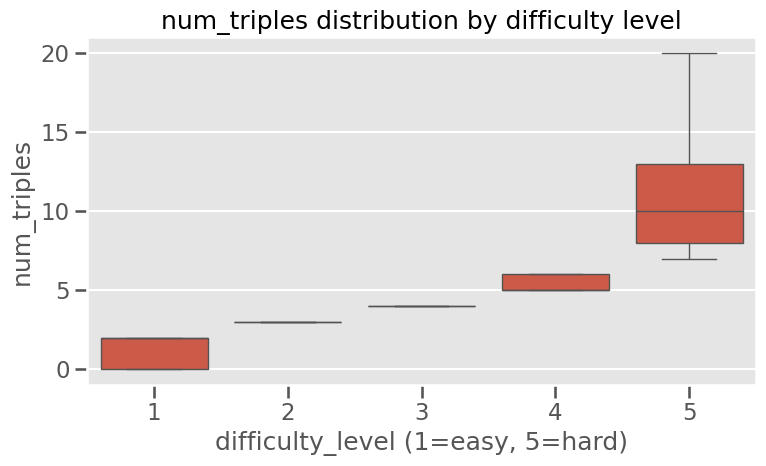

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.boxplot(data=df, x="difficulty_level", y="num_triples", ax=ax)
ax.set_title("num_triples distribution by difficulty level")
ax.set_xlabel("difficulty_level (1=easy, 5=hard)")
ax.set_ylabel("num_triples")

plt.tight_layout()
plt.show()